In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools

from pathlib import Path

### Helper functions

In [5]:
def find_label(target, scale_factor, params):
    template_path = params['template_path']

    template = cv.imread(template_path, 0)
    template = cv.resize(template, (0, 0), fx=scale_factor[1], fy=scale_factor[0])

    method = cv.TM_CCOEFF_NORMED

    x_slice = params['template_area']['x_slice']
    y_slice = params['template_area']['y_slice']

    res = cv.matchTemplate(target[y_slice, x_slice], template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # Determine the bottom-left corner of the matched region
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        origin = min_loc
    else:
        origin = max_loc

    #  Correct for the slice
    origin = (origin[0] + x_slice.start,
              origin[1] + y_slice.start)
    return origin

In [6]:
def image_angle_from_horizontal(vector):
    """Calculates the angle of a 2D vector from the horizontal (x-axis) in degrees."""
    vector = np.array(vector)

    if len(vector) != 2:
        raise ValueError("Vector must be 2D.")

    x, y = vector[0], vector[1]
    angle_radians = np.arctan2(y, x)
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [7]:
def angle_between_vectors(vector1, vector2):
    """Calculates the angle between two vectors in degrees."""
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    if magnitude1 == 0 or magnitude2 == 0:
        # return not a number if a vector has zero magnitude.
        return float('nan')

    cosine_angle = dot_product / (magnitude1 * magnitude2)
    # clip to avoid domain errors.
    angle_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [8]:
def vector_relative_to_origin(origin, vector):
    """Sets the origin of a vector to a new location."""
    vector = np.array(vector)
    origin = np.array(origin)

    return vector - origin

In [9]:
def scale_vector(vector, scale):
    """Scales a vector by a scalar value."""
    vector = np.array(vector)

    return vector * scale

In [10]:
def process_config_files(image_feature_path,
                         user_feature_list_path,
                         chip_map_path):

    image_feature_details = None
    feature_dict = None
    chip_map = None

    try:
        image_feature_details = pd.read_csv(image_feature_path)
    except FileNotFoundError:
        print(f'[INFO]: File not found at {image_feature_path}')

    # Where the labels are according to the user (on the 'real' chip)
    try:
        with open(user_feature_list_path, 'r') as file:
            feature_dict = json.load(file)
    except FileNotFoundError:
        print(f'[ERROR]: File not found at {user_feature_list_path}')
    except json.JSONDecodeError:
        print(f'[ERROR]: Invalid JSON format in {user_feature_list_path}')

    # Where the labels are according to the chip GDSII file
    try:
        with open(chip_map_path, 'r') as file:
            chip_map = json.load(file)
    except FileNotFoundError:
        print(f'[ERROR]: File not found at {chip_map_path}')
    except json.JSONDecodeError:
        print(f'[ERROR]: Invalid JSON format in {chip_map_path}')

    # Filter chip map to only include the chip type we are interested in
    for c in chip_map["chip"]:
        if c["chip_type"] == feature_dict["chip_type"]:
            chip_map = c
            break

    return image_feature_details, feature_dict, chip_map

In [15]:
def find_all_labels(target, image_data, feature_list_path, image_feature_path, 
                    chip_map_path, template_path, scale_factor):

    image_feature_details, feature_dict, chip_map = process_config_files(
        image_feature_path, feature_list_path, chip_map_path)

    # Extract from chip map only the features we are interested in
    if chip_map["auto_locate_grating"]:
        chip_features = feature_dict.get("features", None)
        if not chip_features:
            raise ValueError('[ERROR] No features found in "FeatureLocation.json"')

    feature_labels = [f["label"].lower() for f in chip_features]
    chip_labels = [l for l in chip_map["labels"] if l["label"].lower() in feature_labels]

    # Update chip features with template path and area to search for the feature
    for idx, f in enumerate(chip_features):
        chip_features[idx]["template_path"] = Path(template_path, f'{f['label']}.png')
        if image_feature_details is None:
            chip_features[idx]["template_area"] = {
                "x_slice": slice(f['feature_location'][0] - 100, f['feature_location'][0] + 100),
                "y_slice": slice(f['feature_location'][1] - 100, f['feature_location'][1] + 100),
            }
        else:
            mask = image_feature_details['Label'] == f['label']
            last_row = image_feature_details[mask].iloc[-1]
            chip_features[idx]["template_area"] = {
                "x_slice": slice(last_row['x'] - 100, last_row['x'] + 100),
                "y_slice": slice(last_row['y'] - 100, last_row['y'] + 100),
            }

    if image_feature_details is None:
        image_feature_details = pd.DataFrame(columns=['Image', 'Label', 'x', 'y', 'Timestamp'])
    locs = []
    image_name = image_data['File Path']
    timestamp = image_data['Time Stamp']
    for f in chip_features:
        loc = find_label(target, scale_factor, f)
        new_data = {
            'Image': image_name,
            'Label': f["label"],
            'x': loc[0],
            'y': loc[1],
            'Timestamp': timestamp}
        new_row = pd.DataFrame([new_data])
        image_feature_details = pd.concat([image_feature_details, new_row],
                                          ignore_index=True)
        locs.append(loc)
    image_feature_details.to_csv(image_feature_path, index=False)

    # Calculate the distance between all combinations of chip map and chip feature labels
    loc_combinations = itertools.combinations(range(len(chip_labels)), 2)
    dist_chip_map = []
    dist_chip_feature = []
    for a, b in loc_combinations:
        dist_chip_map.append(vector_relative_to_origin(chip_labels[a]["label_origin"], chip_labels[b]["label_origin"]))
        dist_chip_feature.append(vector_relative_to_origin(locs[a], locs[b]))

    # Cacluate average scaling factor using all combinations of chip map and chip feature distances
    scale_factor = np.round(np.linalg.norm(dist_chip_feature) / np.linalg.norm(dist_chip_map), 4)

    # Calculate the angle between the chip map and chip feature labels separately
    chip_map_angle = image_angle_from_horizontal(vector_relative_to_origin(chip_labels[0]["label_origin"], chip_labels[1]["label_origin"]))
    chip_feature_angle = image_angle_from_horizontal(vector_relative_to_origin(locs[0], locs[1]))

    # Calculate the angle of the image compared to the chip map
    # image can then be rotated by this angle to align with the chip map
    image_angle = np.round(chip_map_angle-chip_feature_angle, 0)

    return scale_factor, image_angle, image_feature_details

In [17]:
def generate_ROI_file(image_feature_path,
                      user_feature_list_path,
                      chip_map_path,
                      ROI_path,
                      target_shape,
                      scale_factor,
                      image_angle):

    image_feature_details, _, chip_map = process_config_files(
            image_feature_path, user_feature_list_path, chip_map_path)
    # assert image_feature_details == None, '[ERROR]: image_features_details still None'

    # Filter chip map to only the gratings and their locations, sizes
    chip_gratings = chip_map.get("gratings", None)

    feature_labels = image_feature_details['Label'].unique()
    feature_labels = [l.lower() for l in feature_labels]
    chip_labels = [l for l in chip_map["labels"]
                if l["label"].lower() in feature_labels]

    locs = []
    for chip_label in chip_labels:
        mask = image_feature_details['Label'] == chip_label["label"]
        last_row = image_feature_details[mask].iloc[-1]
        locs.append((last_row['x'], last_row['y']))

    # Use 'translate_vector' to calculate translation vector to move the chip labels to the feature labels
    # Note: Chip labels location must be scaled before calculating the translation vector
    coord_offset = vector_relative_to_origin(locs[0], scale_vector(
        chip_labels[0]["label_origin"], scale_factor))

    # Add translated grating location to chip grating dictionary
    for idx, g in enumerate(chip_gratings):
        chip_gratings[idx]["grating_origin"] = vector_relative_to_origin(
            coord_offset, scale_vector(g["grating_origin"], scale_factor))

    # Create ROIs for each grating (North and South) using scaled grating sizes
    ROIs = {}
    for g in chip_gratings:
        x, y = g['grating_origin']
        x, y = int(x), int(y)
        if (x < 0 or
            y < 0 or
            x + int(g['x-size'] * scale_factor) > target_shape[1] or
            y + int(g['y-size'] * scale_factor) > target_shape[0]):
            continue
        grating_x_size = int(g['x-size'] * scale_factor)
        grating_y_size = int(g['y-size'] * scale_factor)
        ROIs[f"ROI_{g['label']}_N"] = {
            'label': f'{g['label']}_N',
            'flip': True,
            # 'coords': [x, y + grating_y_size//2],
            # 'size': [grating_x_size, grating_y_size//2],
            'coords': [y + grating_y_size//2, x],
            'size': [grating_y_size//2, grating_x_size],
        }
        ROIs[f"ROI_{g['label']}_S"] = {
            'label': f'{g['label']}_S',
            'flip': False,
            # 'coords': [x, y],
            # 'size': [grating_x_size, grating_y_size//2],
            'coords': [y, x],
            'size': [grating_y_size//2, grating_x_size],
        }
    ROIs['image_angle'] = image_angle
    with open(ROI_path, 'w') as file:
        json.dump(ROIs, file, indent=4)

    return ROIs

### Generate ROI file (ready for analysing)

In [18]:
expt_path = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250225/loc1_1/Split/part1')
img_data_json_name = 'image_metadata_SU000001.json'

img_data = pd.read_json(Path(expt_path, img_data_json_name))
img_data = img_data.T.reset_index(drop=True)
# img_data['Root Path'] = img_data['Root Path'].str.replace('/home/chris/mnt/storage', '/Volumes/krauss')

# for r in img_data.itertuples():
#     print(f"Index: {r.Index}")
#     print(f"Experiment filepath: {r.root_path}")
#     print(f'Image filename: {r.file_path}')
#     print(
#         f'Image filepath: {Path('/Volumes/krauss', r.root_path, r.file_path)}')
#     # img_data.loc[r.Index, 'processed'] = True
#     break

img_path = Path(img_data['Root Path'][0], img_data['File Path'][0])
im = cv.imread(img_path, cv.IMREAD_UNCHANGED)
im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U) # Normalize to 8-bit range (0-255)

user_feature_list_path = Path('../FeatureLocation.json')
image_feature_path = Path('../ImageFeatures_Lisa.csv')
chip_map_path = Path('../Label_templates/Chip_map.json')
template_path = Path('../Label_templates/IMECII/IMEC-II_2')
ROI_path = Path('ROI_ChirpArray.json')
user_scale_factor = (0.75, 0.75)  # Template to image (i.e. template larger than image feature)

scale_factor, image_angle, _ = find_all_labels(im, img_data.iloc[0],
                                               user_feature_list_path,
                                               image_feature_path,
                                               chip_map_path, template_path,
                                               user_scale_factor)

print(f'{scale_factor=}')
print(f'{image_angle=}')

ROIs = generate_ROI_file(image_feature_path,
                         user_feature_list_path,
                         chip_map_path,
                         ROI_path,
                         im.shape,
                         scale_factor,
                         image_angle)

scale_factor=np.float64(0.774)
image_angle=np.float64(-181.0)


### Plot ROIs onto image of chip

/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc2_1/Pos0/img_000000000_Default_000.tif
uint16
(1460, 1920)


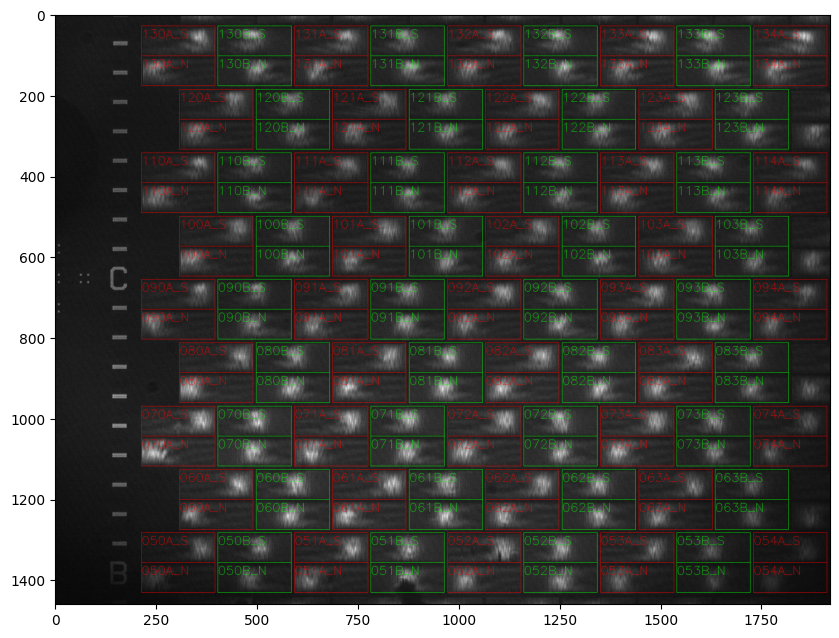

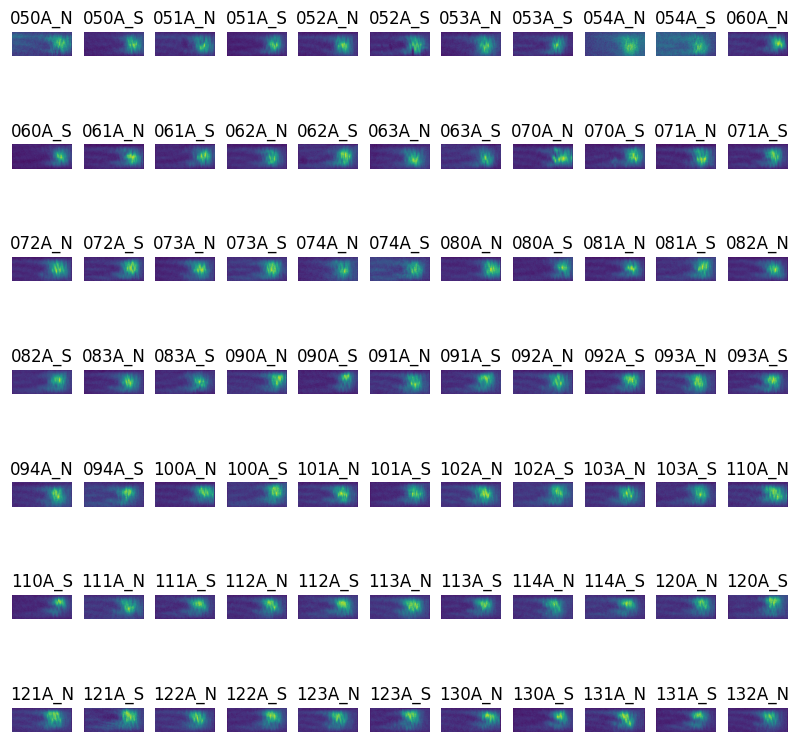

In [ ]:
image_num = 0
file_path = Path(f'img_{image_num:09d}_Default_000.tif')
root_path = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc2_1/Pos0')
img_path = Path(root_path, file_path)
# print(img_path)

raw_im = cv.imread(img_path, cv.IMREAD_UNCHANGED)
raw_im = cv.normalize(raw_im, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)  # Normalize to 8-bit range (0-255)
# print(raw_im.dtype)

# No processing, processing only required for visualising the raw image
im = raw_im

# Equalise Histogram
# im = cv.equalizeHist(raw_im)

# # Contrast stretching
# min_val, max_val = np.min(raw_im), np.max(raw_im)
# im = cv.normalize(raw_im, None, 0, 255, cv.NORM_MINMAX)

# # Adaptive histogram equalisation
# clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # clipLimit controls contrast, tileGridSize sets region size
# im = clahe.apply(raw_im)

# # Gamma correction
# gamma = 0.01  # Adjust this value
# im = np.power(raw_im / 255.0, gamma) * 255.0
# im = im.astype(np.uint8)

# # Manual bightness (beta) and contrast (alpha) adjustment
# alpha = 200  # Contrast control (1.0 = no change, >1 increases contrast)
# beta = 10    # Brightness control (positive = brighter, negative = darker)
# im = cv.convertScaleAbs(raw_im, alpha=alpha, beta=beta)

print(im.shape)

ROI_path = Path('ROI_ChirpArray.json')
with open(ROI_path, 'r') as file:
    ROIs = json.load(file)

# Display grating locations on the image for visual confirmation
im_color = cv.cvtColor(im, cv.COLOR_GRAY2BGR)
for k, v in ROIs.items():
    if k == 'image_angle':
        continue
    if '_2_' in k:
        continue
    # x, y = v['coords']
    # x_size, y_size = v['size']
    y, x = v['coords']
    y_size, x_size = v['size']
    color = (255, 0, 0)
    if 'B' in v['label']:
        color = (0, 255, 0)
    cv.rectangle(im_color, (x, y + y_size), (x + x_size, y), color, 1)
    cv.putText(im_color, v['label'], (x, y + 30),
                cv.FONT_HERSHEY_SIMPLEX, 1, color, 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(im_color)
# ax.invert_yaxis()
plt.show()

# Display ROIs on the image for visual confirmation
fig, ax = plt.subplots(7, 11, figsize=(10, 10))
a = ax.ravel()
count = 0
for k, v in ROIs.items():
    if k == 'image_angle':
        continue
    if '_2_' in k:
        continue
    # x_slice = slice(v['coords'][0], v['coords'][0] + v['size'][0])
    # y_slice = slice(v['coords'][1], v['coords'][1] + v['size'][1])
    y_slice = slice(v['coords'][0], v['coords'][0] + v['size'][0])
    x_slice = slice(v['coords'][1], v['coords'][1] + v['size'][1])
    data = im[y_slice, x_slice]
    if v['flip']:
        data = np.fliplr(data)
    try:
        a[count].imshow(data)
        a[count].set_title(v['label'])
        a[count].axis('off')
        count += 1
    except:
        pass
plt.show()

### Measure label locations for all images in experiment
Used to look for sample drift

In [ ]:
expt_path = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
img_data_json_name = 'image_metadata_SU000001_1.json'

img_data = pd.read_json(Path(expt_path, img_data_json_name))
img_data = img_data.T.reset_index(drop=True)
# img_data.columns = img_data.columns.str.replace(' ', '_').str.lower()
# img_data['root_path'] = img_data['root_path'].str.replace('K:/', '')

user_feature_list_path = Path('FeatureLocation.json')
image_feature_path = Path('ImageFeatures.csv')
chip_map_path = Path('Label_templates/Chip_map.json')
template_path = Path('Label_templates/IMECII/IMEC-II_2')
ROI_path = Path('ROI_ChirpArray.json')

# Scale factor for template to image (i.e. template larger than image feature)
user_scale_factor = (0.75, 0.75)

image_feature_list = []
for _, row in img_data.iterrows():
    print(f'Index: {row['Index']} \t Image filename: {row['File Path']}')
    # img_data.loc[r.Index, 'processed'] = True

    img_path = Path(row['Root Path'], row['File Path'])
    im = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U) # Normalize to 8-bit range (0-255)

    target = np.fliplr(im)
    target_shape = target.shape

    scale_factor, image_angle, features = find_all_labels(target, row,
                                                user_feature_list_path,
                                                image_feature_path,
                                                chip_map_path, template_path,
                                                user_scale_factor)

    image_feature_list.append(features)
    break
image_feature_details = pd.concat(image_feature_list, ignore_index=True)
image_feature_details.to_csv(image_feature_path, index=False)

AttributeError: 'Series' object has no attribute 'Index'

### Make video of chirp-array

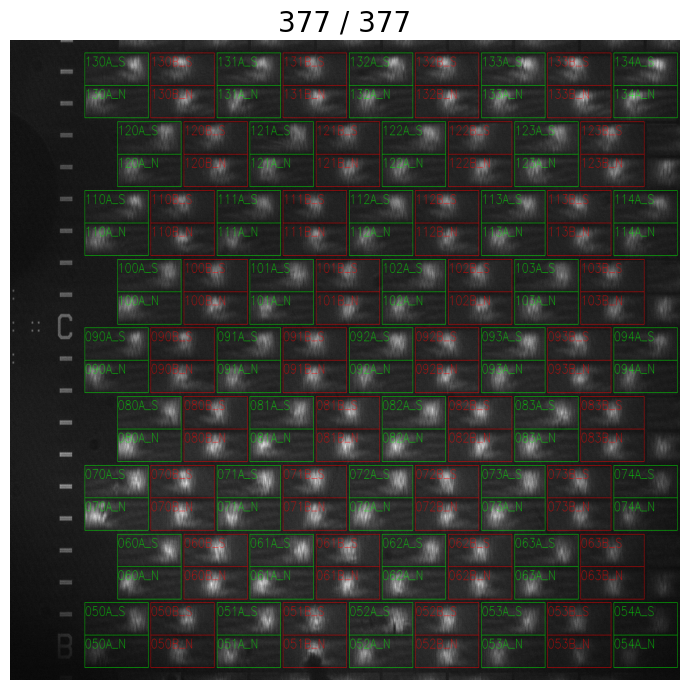

In [5]:
from matplotlib.animation import FFMpegWriter
from matplotlib.offsetbox import AnchoredText

starting_img_num = 0
total_num_imgs = 377

writer = FFMpegWriter(fps=30)

file_path = Path(f'img_{starting_img_num:09d}_Default_000.tif')
root_path = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc2_1/Pos0')
video_filepath = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results', 'Chirp_video.mp4')
ROI_path = Path('ROI_ChirpArray.json')

with open(ROI_path, 'r') as file:
    ROIs = json.load(file)

img_path = Path(root_path, file_path)
# print(img_path)

raw_im = cv.imread(img_path, cv.IMREAD_UNCHANGED)
im = cv.normalize(raw_im, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U) # Normalize to 8-bit range (0-255)
# print(im.shape)

fig, ax = plt.subplots(1, 1, figsize=(7, 7), layout='tight')
ax.axis('off')
ax.set_title(f'{0:03d} / {total_num_imgs}', fontsize=20)

# Display grating locations on the image for visual confirmation
im_color = cv.cvtColor(im, cv.COLOR_GRAY2BGR)
for k, v in ROIs.items():
    if k == 'image_angle':
        continue
    y, x = v['coords']
    y_size, x_size = v['size']
    color = (255, 0, 0)
    if '_1_' in v['label']:
        color = (0, 255, 0)
    cv.rectangle(im_color, (x, y + y_size), (x + x_size, y), color, 1)
    cv.putText(im_color, v['label'], (x, y + 30),
                cv.FONT_HERSHEY_SIMPLEX, 1, color, 1)


img_chirp = ax.imshow(im_color, aspect='auto', cmap='gray', vmin=0, vmax=1)

with writer.saving(fig, video_filepath, dpi=100):
    for idx in range(0, total_num_imgs + 1):
        file_path = Path(f'img_{idx:09d}_Default_000.tif')
        img_path = Path(root_path, file_path)
        temp = cv.imread(img_path, cv.IMREAD_UNCHANGED)
        temp = cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U) # Normalize to 8-bit range (0-255)

        temp_color = cv.cvtColor(temp, cv.COLOR_GRAY2BGR)
        for k, v in ROIs.items():
            if k == 'image_angle':
                continue
            y, x = v['coords']
            y_size, x_size = v['size']
            color = (255, 0, 0)
            if 'A_' in v['label']:
                color = (0, 255, 0)
            cv.rectangle(temp_color, (x, y + y_size), (x + x_size, y), color, 1)
            cv.putText(temp_color, v['label'], (x, y + 30),
                        cv.FONT_HERSHEY_SIMPLEX, 1, color, 1)

        img_chirp.set_data(temp_color)
        ax.set_title(f'{idx:03d} / {total_num_imgs}', fontsize=20)

        writer.grab_frame()
        print(f'Frame {idx + 1} of {total_num_imgs} written', end='\r')